# Effective Convergence
*24 January 2020*

In this notebook, we'll be using an idea I didn't realize up till now, that we can define the effective convergence as:
$$\kappa_\mathrm{eff} = \frac{1}{2} \nabla \cdot \vec\alpha$$
(thanks to [Gilman+ 2019](https://arxiv.org/pdf/1901.11031.pdf)).

Note that we're updating from `lenstronomy 1.0.1` to `1.3.0` (this new version has tNFW profiles).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

from scipy import fftpack
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad
from scipy.stats import poisson

from helpers import CustomImage, autoshow

In [2]:
# Basic parameters
zl = 0.5
zs = 1.
# pixnum, pixsize = 200, .008 # to match S. Birrer's paper (roughly)
# ext = pixnum * pixsize / 2.
pixnum = 200
ext = 0.8 # should be .8 to match Simon's paper
pixsize = 2*ext / pixnum
print(pixsize)

0.008


In [3]:
## Calculate physical size of image
# ( note: 845000 kpc to z=.2 )
# distance = 1947000 # kpc to z=.5

cosmo = FlatLambdaCDM(H0=70, Om0=0.316)

com_l = cosmo.comoving_distance(zl).to(u.kpc).value
com_s = cosmo.comoving_distance(zs).to(u.kpc).value
angle = (2*ext) * np.pi/648000 # rad
com_width_kpc = com_l * angle # comoving width in kpc
print(com_width_kpc, 'kpc')

14.569745638522322 kpc


In [4]:
# vol_rough = com_width_kpc**2 * com_s # kpc^3
# # 3.391e6
# print('comoving volume is approx', vol_rough / 1e6, 'million kpc^3')
# del vol_rough

## Double cone shape

In [5]:
def double_cone_direct(com_z, com_l, com_s):
    # Input can be in any units
    if com_z < com_l:
        return com_z / com_l
    else:
        return (com_s - com_z) / (com_s - com_l)

def double_cone(z, zl=zl, zs=zs):
    com_z = cosmo.comoving_distance(z)
    com_l = cosmo.comoving_distance(zl)
    com_s = cosmo.comoving_distance(zs)
    return double_cone_direct(com_z, com_l, com_s)

zlist = np.linspace(0, zs, 100)
doubleconelist = [double_cone(z) for z in zlist]
comlist = [cosmo.comoving_distance(z).to(u.Mpc).value for z in zlist]

# plt.plot(zlist, [double_cone(z) for z in zlist]); plt.show()
# plt.plot(comlist, doubleconelist); plt.show()

com_l = cosmo.comoving_distance(zl).to(u.kpc).value
com_s = cosmo.comoving_distance(zs).to(u.kpc).value
print('com_l', com_l, 'com_s', com_s)
print('integral (in kpc)', quad(double_cone_direct, 0, com_s, args=(com_l, com_s)))

double_cone_volume_kpc = com_width_kpc**2 * quad(double_cone_direct, 0, com_s, args=(com_l, com_s))[0] # volume of double-cone in kpc**3 (really double prism)

print('double prism volume', double_cone_volume_kpc / 1e6, 'million kpc^3')

com_l 1878266.1007495527 com_s 3273038.879969728
integral (in kpc) (1636519.4398168526, 0.024362179450690746)
double prism volume 347.3962357004227 million kpc^3


## Substructure
### Interlopers

Units: `massesn` has units of $M_\odot$. `massfunc` has units of 1/(Mpc/h)^3 / M_sun (comoving distance).

In [6]:
# Load Press-Schechter results
h = .675
massesn = np.load('files/ps_results/massesn_wide.npy') # units solar masses
massfunc_matrix = np.load('files/ps_results/massfunc_wide.npy') * h**3/1000**3 # convert Mpc/h^3 to 1/kpc^3
zlist = np.load('files/ps_results/zs_wide.npy') # redshifts

massfunc = interp2d(zlist, massesn, massfunc_matrix, bounds_error=False) # function of (z, mass)

In [7]:
def ps_integrand(mass):
    # rough so ignore redshift dependence
    return massfunc(.5, mass)

mass_bins_interlopers: [5.01187234e+05 3.63078055e+06 2.63026799e+07 1.90546072e+08
 1.38038426e+09]
number 138.9526614470909


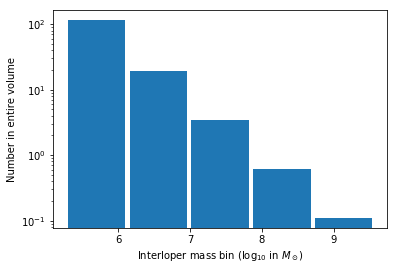

In [8]:
# Very simplified: just sorting halos into bins of powers of 10
mass_bins_interlopers = np.logspace(5.7,10,6)[:-1]
bin_ratio = mass_bins_interlopers[1]/mass_bins_interlopers[0]
print('mass_bins_interlopers:',mass_bins_interlopers)
avg_nums_interlopers = np.array([double_cone_volume_kpc * quad(ps_integrand, mass, bin_ratio*mass)[0] for mass in mass_bins_interlopers])
plt.bar(np.log10(mass_bins_interlopers), avg_nums_interlopers, log=True)
plt.xlabel(r'Interloper mass bin ($\log_{10}$ in $M_\odot$)')
plt.ylabel('Number in entire volume')
print('number', np.sum(avg_nums_interlopers))

### Subhalos

Just a very rough estimate of the mass function:

In [9]:
from helpers import ADD
phys_width_kpc = 2 * ext * np.pi/648000  * ADD(0, zl).to(u.kpc).value
print('phys width (kpc):', phys_width_kpc)

phys width (kpc): 9.713163759014881


In [10]:
Sigma_sub = 0.012 # kpc^-2
m0 = 1e8 # Msun
dNdm_sub = lambda m: Sigma_sub / m0 * (m / m0)**-1.9 * phys_width_kpc**2 # 1/Msun
# I think we should use the physical width, but not 100% sure

In [11]:
np.logspace(5.7,10,5)

array([5.01187234e+05, 5.95662144e+06, 7.07945784e+07, 8.41395142e+08,
       1.00000000e+10])

mass bins sub: ['501187', '3.63078e+06', '2.63027e+07', '1.90546e+08', '1.38038e+09']
number 147.77520466462553


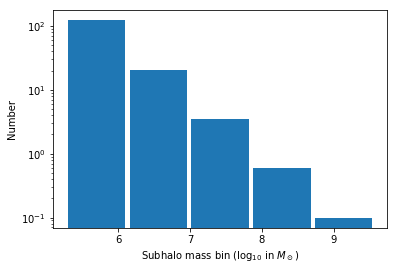

In [12]:
mass_bins_sub = np.logspace(5.7,10,6)[:-1]
bin_ratio = mass_bins_sub[1]/mass_bins_sub[0]
print('mass bins sub:', ['%g'%x for x in mass_bins_sub])
avg_nums_sub = np.array([quad(dNdm_sub, mass, bin_ratio * mass)[0] for mass in mass_bins_sub])
plt.bar(np.log10(mass_bins_sub), avg_nums_sub, log=True)
plt.xlabel(r'Subhalo mass bin ($\log_{10}$ in $M_\odot$)')
plt.ylabel('Number')
print('number', np.sum(avg_nums_sub))

### Sampling

In [13]:
def double_cone_angle(z, zl=zl, zs=zs):
    # angle of how wide the interloeprs can be dispersed so that they'd show up in the final image (according to the double-prism projection)
    
    # returns a ratio, 1 for z <= zl
    
    com_z = cosmo.comoving_distance(z)
    com_l = cosmo.comoving_distance(zl)
    return double_cone(z, zl=zl, zs=zs) * com_l / com_z

#plt.plot(zlist, [double_cone_angle(z) for z in zlist])

In [14]:
# Populate the interlopers and subhalos

np.random.seed(145)
n_planes = 10

xs, ys, redshifts, masses = [], [], [], []
#xyext = ext

z_planes = np.linspace(.05,.95,n_planes)
area_proportions = [double_cone(z)**2 for z in z_planes]
area_sum = np.sum(area_proportions)

for i, z_plane in enumerate(z_planes):
    rv_nums = poisson.rvs(avg_nums_interlopers * area_proportions[i] / area_sum)
    xyext = ext * double_cone_angle(z_plane)
    # ^- I thought about multiplying this by 1.5 so we don't get weird boundary effects
    #print(rv_nums)
    for mass, num in zip(mass_bins_interlopers, rv_nums):
        for i in range(num):
            xs.append(np.random.uniform(-xyext,xyext))
            ys.append(np.random.uniform(-xyext,xyext))
            redshifts.append(z_plane)
            masses.append(mass)
print('number of interlopers', len(xs))
rv_nums = poisson.rvs(avg_nums_sub) if len(avg_nums_sub) > 1 else [poisson.rvs(avg_nums_sub)]
xyext = ext
for mass, num in zip(mass_bins_sub, rv_nums):
    for i in range(num):
        xs.append(np.random.uniform(-xyext,xyext))
        ys.append(np.random.uniform(-xyext,xyext))
        redshifts.append(zl)
        masses.append(mass)
print('number of subhalos + interlopers', len(xs))

number of interlopers 116
number of subhalos + interlopers 256


In [15]:
# # These are the (somewhat arbitrary) lens system settings used to create the sample image:
# zl = 0.2
# xs = [0,.2]
# ys = [0.5,-.2]
# redshifts = [.2,.25]

In [16]:
# # Now we'll try something more intense
# np.random.seed(123)


# xs, ys, redshifts, masses = [], [], [], []
# for i in range(50):
#     xs.append( np.random.uniform(-.3*ext,.3*ext) )
#     ys.append( np.random.uniform(-.3*ext,.3*ext) )
#     redshifts.append( np.random.uniform(0,1) ) 
#     masses.append( 1e8 )

---
### But first some tests: subhalos only

In [17]:
# Populate the subhalos

np.random.seed(145)
# n_planes = 10

xs, ys, redshifts, masses = [], [], [], []
#xyext = ext

# z_planes = np.linspace(.05,.95,n_planes)
# area_proportions = [double_cone(z)**2 for z in z_planes]
# area_sum = np.sum(area_proportions)

# for i, z_plane in enumerate(z_planes):
#     rv_nums = poisson.rvs(avg_nums_interlopers * area_proportions[i] / area_sum)
#     xyext = ext * double_cone_angle(z_plane)
#     # ^- I thought about multiplying this by 1.5 so we don't get weird boundary effects
#     #print(rv_nums)
#     for mass, num in zip(mass_bins_interlopers, rv_nums):
#         for i in range(num):
#             xs.append(np.random.uniform(-xyext,xyext))
#             ys.append(np.random.uniform(-xyext,xyext))
#             redshifts.append(z_plane)
#             masses.append(mass)
# print('number of interlopers', len(xs))
rv_nums = poisson.rvs(avg_nums_sub) if len(avg_nums_sub) > 1 else [poisson.rvs(avg_nums_sub)]
xyext = ext
for mass, num in zip(mass_bins_sub, rv_nums):
    for i in range(num):
        xs.append(np.random.uniform(-xyext,xyext))
        ys.append(np.random.uniform(-xyext,xyext))
        redshifts.append(zl)
        masses.append(mass)
print('number of subhalos', len(xs))

number of subhalos 144


In [18]:
myimg_sub = CustomImage(xs, ys, redshifts, zl=zl, m=masses, pixnum=pixnum, pixsize=pixsize, mass_sheets=False)
#myimg_sub = CustomImage([], [], [], zl=zl, m=[], pixnum=pixnum, pixsize=pixsize, mass_sheets=False, main_theta=1e-3)

new result of alpha_rs is 1.2135229034175085e-05
old result would have been 0.00036458788397843606


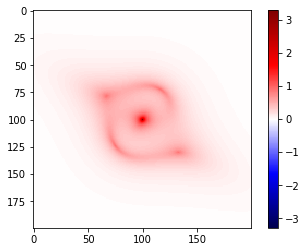

In [19]:
blankimg = CustomImage([],[],[], zl=zl, pixnum=pixnum, pixsize=pixsize)
autoshow(blankimg.image)
blankimg.calc_div_curl();

In [20]:
%%time
myimg_sub.calc_div_curl();

KeyboardInterrupt: 

In [21]:
autoshow(myimg_sub.divmat - blankimg.divmat, ext=ext, vmax=.09)
plt.title(r'$\kappa_{sub}$ (single plane, CDM)')
#plt.savefig('imgs/feb11_subs_only_r1e-4adj.png')

AttributeError: 'CustomImage' object has no attribute 'divmat'

### Next, try projection map

In [22]:
# Populate the interlopers in projection (middle picture in Fig 2 of Birrer's paper)

np.random.seed(145)
n_planes = 10

xs, ys, redshifts, masses = [], [], [], []
mass_sheets = []
#xyext = ext

# Interlopers!
z_planes = np.linspace(.01,.99,n_planes)
area_proportions = [double_cone(z)**2 for z in z_planes]
area_sum = np.sum(area_proportions)

for i, z_plane in enumerate(z_planes):
    rv_nums = poisson.rvs(avg_nums_interlopers * area_proportions[i] / area_sum)
    xyext = ext # * double_cone_angle(z_plane)
    # ^- I thought about multiplying this by 1.5 so we don't get weird boundary effects
    #print(rv_nums)
    for mass, num in zip(mass_bins_interlopers, rv_nums):
        for i in range(num):
            xs.append(np.random.uniform(-xyext,xyext))
            ys.append(np.random.uniform(-xyext,xyext))
            redshifts.append(zl)
            masses.append(mass)
            mass_sheets.append(True)
print('number of interlopers', len(xs))

# Subhalos!
rv_nums = poisson.rvs(avg_nums_sub) if len(avg_nums_sub) > 1 else [poisson.rvs(avg_nums_sub)]
xyext = ext
for mass, num in zip(mass_bins_sub, rv_nums):
    for i in range(num):
        xs.append(np.random.uniform(-xyext,xyext))
        ys.append(np.random.uniform(-xyext,xyext))
        redshifts.append(zl)
        masses.append(mass)
        mass_sheets.append(False)
print('number of interlopers + subhalos', len(xs))

number of interlopers 128
number of interlopers + subhalos 274


In [23]:
myimg_proj = CustomImage(xs,ys,redshifts, zl=zl, m=masses, pixnum=pixnum, pixsize=pixsize, mass_sheets=mass_sheets)

new result of alpha_rs is 1.2135229034175085e-05
old result would have been 0.00036458788397843606
showing work
z 0.5 m 394193194.8044429
area_com 212.27748797124022
area 94.34555020944009
sig 4178185.3402663227


In [24]:
%%time
myimg_proj.calc_div_curl();

CPU times: user 7min 38s, sys: 12 ms, total: 7min 38s
Wall time: 7min 38s


(array([[0.19098162, 0.19101786, 0.19190305, ..., 0.37015766, 0.36869107,
         0.3685223 ],
        [0.19190477, 0.19184543, 0.19266056, ..., 0.37099161, 0.36948834,
         0.36929701],
        [0.19446733, 0.19481801, 0.19458809, ..., 0.37332227, 0.37177377,
         0.37155066],
        ...,
        [0.37225814, 0.37254858, 0.37416639, ..., 0.19624215, 0.19529751,
         0.19508931],
        [0.37002201, 0.37028159, 0.37185289, ..., 0.19506813, 0.19413554,
         0.19393702],
        [0.36928999, 0.3695273 , 0.37106262, ..., 0.19470827, 0.19378421,
         0.19359169]]),
 array([[-2.63461231e-04, -2.76014604e-04, -1.98035147e-04, ...,
          6.15612136e-04,  5.94737741e-04,  2.15661727e-04],
        [ 1.36907118e-05,  3.75584501e-05,  6.53291409e-05, ...,
          2.19906639e-06,  1.78376938e-06, -3.77435212e-04],
        [ 3.03833578e-04,  7.77948205e-05, -1.34310979e-04, ...,
          1.90273423e-06,  1.47232627e-06, -3.98652545e-04],
        ...,
        [-4.218331

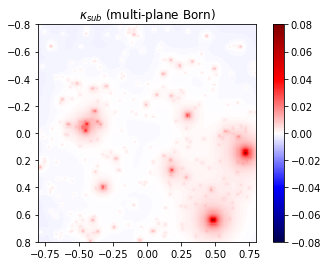

In [26]:
autoshow(myimg_proj.divmat-blankimg.divmat, ext=ext, vmax=.08)
#plt.title(r'$\kappa_{sub}$ (multi-plane Born)')
#plt.savefig('imgs/feb11_mpborn_orig.png')

In [30]:
#autoshow(myimg_proj.divmat-blankimg.divmat - .002, ext=ext, vmax=.08)
#plt.title(r'$\kappa_{sub}$ (multi-plane Born) + more mass sheet')
#plt.savefig('imgs/feb11_mpborn_offset.png')

Text(0.5, 1.0, '$\\kappa_{sub}$ (multi-plane Born): High Contrast')

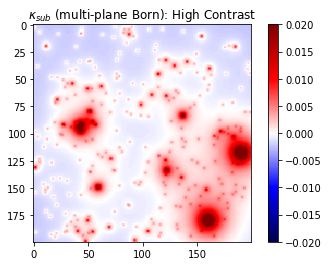

In [33]:
autoshow(myimg_proj.divmat-blankimg.divmat, vmax=.02)
plt.title(r'$\kappa_{sub}$ (multi-plane Born): High Contrast')

### Finally, the actual image:

In [34]:
# Populate the interlopers and subhalos

np.random.seed(145)
n_planes = 10

xs, ys, redshifts, masses = [], [], [], []
mass_sheets = []
#xyext = ext

z_planes = np.linspace(.01,.99,n_planes)
area_proportions = [double_cone(z)**2 for z in z_planes]
area_sum = np.sum(area_proportions)

# Interlopers
for i, z_plane in enumerate(z_planes):
    rv_nums = poisson.rvs(avg_nums_interlopers * area_proportions[i] / area_sum)
    xyext = ext * double_cone_angle(z_plane)
    # ^- I thought about multiplying this by 1.5 so we don't get weird boundary effects
    #print(rv_nums)
    for mass, num in zip(mass_bins_interlopers, rv_nums):
        for i in range(num):
            xs.append(np.random.uniform(-xyext,xyext))
            ys.append(np.random.uniform(-xyext,xyext))
            redshifts.append(z_plane)
            masses.append(mass)
            mass_sheets.append(True)
print('number of interlopers', len(xs))
# Subhalos
rv_nums = poisson.rvs(avg_nums_sub) if len(avg_nums_sub) > 1 else [poisson.rvs(avg_nums_sub)]
xyext = ext
for mass, num in zip(mass_bins_sub, rv_nums):
    for i in range(num):
        xs.append(np.random.uniform(-xyext,xyext))
        ys.append(np.random.uniform(-xyext,xyext))
        redshifts.append(zl)
        masses.append(mass)
        mass_sheets.append(False)
print('number of subhalos + interlopers', len(xs))

number of interlopers 128
number of subhalos + interlopers 274


In [35]:
myimg = CustomImage(xs, ys, redshifts, zl=zl, m=masses, pixnum=pixnum, pixsize=pixsize, mass_sheets=mass_sheets, main_theta=1.0)

new result of alpha_rs is 2.4174270088518478e-05
old result would have been 0.000256368065661692
showing work
z 0.11888888888888888 m 5635529.482210107
area_com 14.716615651173662
area 11.755308350435401
sig 479402.9483710969
showing work
z 0.22777777777777777 m 36070177.18249221
area_com 51.06652981948139
area 33.87636547472814
sig 1064759.3588338355
showing work
z 0.33666666666666667 m 31307240.725124277
area_com 105.25631004048202
area 58.9117474620393
sig 531426.1089487727
showing work
z 0.44555555555555554 m 59492199.66627707
area_com 173.70729607503418
area 83.12822089835568
sig 715667.9046339829
showing work
z 0.5 m 0
area_com 212.27748797124022
area 94.34555020944009
sig 0.0
showing work
z 0.5544444444444444 m 207330190.3306454
area_com 162.7931319617484
area 67.3729662354639
sig 3077349.8914392544
showing work
z 0.6633333333333333 m 24546866.86334952
area_com 86.74752432787575
area 31.354400944208326
sig 782884.2562493202
showing work
z 0.7722222222222221 m 29309803.320717447


In [36]:
%%time
myimg.calc_div_curl()
0

CPU times: user 8min 5s, sys: 12 ms, total: 8min 5s
Wall time: 8min 5s


0

In [37]:
blankimg = CustomImage([], [], [], zl=zl, m=[], pixnum=pixnum, pixsize=pixsize, mass_sheets=[], main_theta=1.0)
blankimg.calc_div_curl();

Text(0.5, 1.0, '$\\kappa_\\mathrm{eff}$ (theta=1)')

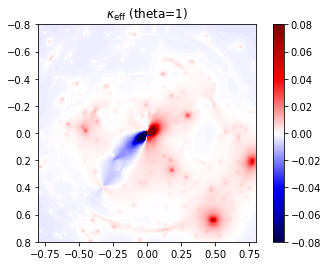

In [43]:
autoshow(myimg.divmat - blankimg.divmat, ext=ext, vmax=.08)
plt.title(r'$\kappa_\mathrm{eff}$ (theta=1)')
#plt.savefig('imgs/feb11_final_theta1.png')

In [44]:
# np.save('files/full_alpha.npy', [myimg.alphamat_x, myimg.alphamat_y])

# np.save('files/macro_alpha.npy', [blankimg.alphamat_x, blankimg.alphamat_y])

# np.save('files/diff_alpha.npy', [myimg.alphamat_x - blankimg.alphamat_x, myimg.alphamat_y - blankimg.alphamat_y])

In [41]:
# autoshow(myimg.divmat - blankimg.divmat - .003, ext=ext, vmax=.08)
# plt.title(r'$\kappa_\mathrm{eff}$ (theta=1) + offset')
# plt.savefig('imgs/feb11_final_theta1_offset.png')

---

In [ ]:
autoshow(myimg.image)

In [ ]:
autoshow(myimg.image - blankimg.image, vmax=5)

In [ ]:
flat_redshifts = [zl] * len(xs)
flatimg = CustomImage(xs, ys, flat_redshifts, zl=zl, m=masses, pixnum=pixnum, pixsize=pixsize)

In [ ]:
autoshow(flatimg.image - blankimg.image)

In [ ]:
# vmin = np.min(myimg.image - blankimg.image)
# vmax = np.max(myimg.image - blankimg.image)
# vmin = min(vmin, -vmax)
# vmax = max(vmax, -vmin)

# plt.imshow(myimg.image - blankimg.image, vmin=vmin, vmax=vmax, cmap='seismic')
# plt.colorbar()
# plt.scatter([myimg.x_to_pix(x,z) for x,z in zip(xs, redshifts)],
#             [myimg.x_to_pix(y,z) for y,z in zip(ys, redshifts)], color='black', marker='+', label='interloper/subhalo')
# plt.scatter([myimg.x_to_pix(0)], [myimg.x_to_pix(0)], color='black', label='main lens')

# leg = plt.legend()
# #leg.get_frame().set_linewidth(3)
# leg.get_frame().set_edgecolor('k')

# plt.title('Pixel residual from substructure', size=16)

# #plt.savefig('imgs/jan26_sample_residuals.pdf')

# plt.show()

In [ ]:
# myimg.lens_model_mp.ray_shooting(0,0,myimg.kwargs_lens)
# myimg.lens_model_mp.ray_shooting(-10,0,myimg.kwargs_lens)
# myimg.pixel_grid.map_pix2coord(140, 0)

# alphamat_x = np.zeros((myimg.pixnum, myimg.pixnum))
# alphamat_y = np.zeros((myimg.pixnum, myimg.pixnum))
# alphamat_mag = np.zeros((myimg.pixnum, myimg.pixnum))
# for xpix in range(myimg.pixnum):
#     for ypix in range(myimg.pixnum):
#         image_xy = myimg.pixel_grid.map_pix2coord(xpix, ypix) # in angle units
#         source_xy = myimg.lens_model_mp.ray_shooting(image_xy[0], image_xy[1], myimg.kwargs_lens)
#         alphamat_x[xpix,ypix] = image_xy[0] - source_xy[0]
#         alphamat_y[xpix,ypix] = image_xy[1] - source_xy[1]
#         alphatmat_mag = np.sqrt(alphamat_x[xpix,ypix]**2 + alphamat_y[xpix,ypix]**2)

# divmat = np.gradient(alphamat_x, myimg.pixsize)[0] + np.gradient(alphamat_y, myimg.pixsize)[1]
# curlmat = np.gradient(alphamat_y, myimg.pixsize)[0] - np.gradient(alphamat_x, myimg.pixsize)[1]

In [ ]:
divmat, curlmat = myimg.calc_div_curl();

In [ ]:
divmat_blank, curlmat_blank = blankimg.calc_div_curl();

In [ ]:
divmat_flat, curlmat_flat = flatimg.calc_div_curl();

In [ ]:
np.sum(divmat) - np.sum(divmat_blank)

In [ ]:
np.sum(divmat) - np.sum(divmat_blank)

In [ ]:
np.sum(divmat_flat) - np.sum(divmat_blank)

In [ ]:
autoshow(divmat, ext=ext)

In [ ]:
autoshow(divmat - divmat_blank, vmax=3, ext=ext)

In [ ]:
autoshow(divmat - divmat_blank, vmax=3, ext=ext)
#plt.savefig('imgs/feb10_nosub_theta.3.png')

In [ ]:
autoshow(divmat - divmat_blank, vmax=.04, ext=ext)
#plt.savefig('imgs/feb4_nosub_theta.3.png')
# this particular picture showing right now (maybe not when you restart the kernel) is with mass sheets but no subhalos

In [ ]:
autoshow(divmat_flat - divmat_blank, vmax=None)

In [ ]:
autoshow(curlmat - curlmat_blank, vmax=.001)

In [ ]:
image = (divmat - divmat_blank).T
outer_image = image.copy()
for xpix in range(myimg.pixnum//2 - 2, myimg.pixnum//2 + 2):
    for ypix in range(myimg.pixnum//2 - 2, myimg.pixnum//2 + 2):
        outer_image[xpix,ypix] = 0
autoshow(image, ext=ext)
plt.show()
autoshow(outer_image, ext=ext)

In [ ]:
vmax = .08
plt.imshow(outer_image, vmin=-vmax, vmax=vmax, cmap='seismic', extent=[-ext,ext,ext,-ext])
plt.colorbar()

In [ ]:
plt.imshow(np.log10(outer_image), cmap='inferno')
plt.imshow(np.log10(-outer_image), cmap='viridis')

In [ ]:
#np.save('files/myimg_247interlopers.npy', myimg)

In [ ]:
# image_flat = (divmat_flat - divmat_blank).T
# autoshow(image_flat, ext=ext)

In [ ]:
#np.save('files/myimg247.npy', myimg)
#np.save('files/flatimg247.npy', flatimg)

## Fourier transform

In [ ]:
# np.save('files/outer_image71.npy', image)

In [ ]:
# np.save('files/outer_imageflat71.npy', image_flat)

In [ ]:
image_width_kpc

Why does `side` have to be an integer? It is the length of the image in kpc.

In [ ]:
!python2 make_mask.py --pix_num=200 --side=7

In [ ]:
!python2 power_spectrum.py \
--conv_file1 files/outer_imageflat71.npy \
--kdir files/ \
--psdir files/ \
--pix_num 200 \
--side 7 \
--name testDM \
# --z 0.2 \
# --m_high 1e-2 \
# --m_low 1e-4 \
--num_proj 1 \
--sigma_crit 3.14e9

In [ ]:
klist = np.loadtxt('files/ktestDM_095_200_7.txt')
plist = np.load('files/ind_curves_testDM_095_200_7.npy')

In [ ]:
plt.loglog(klist, plist[0])
plt.xlabel(r'$k$ (1/kpc)')
plt.ylabel(r'Power (kpc^2)')

# Old cells

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

ratio = 1e5
# check that title is correctly set to the ratio

#vmin = min(np.min(divmat), np.min(divmat_blank), ratio*np.min(divmat-divmat_blank))
#vmax = max(np.max(divmat), np.max(divmat_blank), ratio*np.max(divmat-divmat_blank))
vmax=8000
vmin = -vmax

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(divmat.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(divmat_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[1].set_title('Macro only')
im2 = axs[2].imshow(ratio*(divmat-divmat_blank).T, 
              vmin=vmin, vmax=vmax,
              extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[2].set_title('Difference $\\times 10^5$')

plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\cdot\vec\alpha$ (500 interlopers of mass $10^7\, M_\odot$)', size=20)

#plt.savefig('imgs/jan30_sample500_scaled.png')
plt.show()

In [ ]:
plt.imshow(np.log10(0.5*divmat_blank.T), extent=[-ext,ext,ext,-ext], cmap='inferno')
plt.colorbar()
plt.title(r'$\log_{10}$ convergence')
plt.tight_layout()
plt.savefig('imgs/jan30_logmacro.png')

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

vmin = -1e-4#min(np.min(curlmat), np.min(curlmat_blank))
vmax = 1e-4#max(np.max(curlmat), np.max(curlmat_blank))

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(curlmat.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(curlmat_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[1].set_title('Macro only')
axs[2].imshow((curlmat-curlmat_blank).T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[2].set_title('Difference')
plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\times\vec\alpha$ (200x200 pixels)', size=20)

#plt.savefig('imgs/jan27_sample20_curls.png')

plt.show()

## Test if curl pattern is a numerical error

In [ ]:
blankimg2 = CustomImage([],[],[], zl=zl,              pixnum=400, pixsize=.004)

myimg2 = CustomImage(xs, ys, redshifts, zl=zl, m=1e7, pixnum=400, pixsize=.004)

vmin = np.min(myimg2.image - blankimg2.image)
vmax = np.max(myimg2.image - blankimg2.image)
vmin = min(vmin, -vmax)
vmax = max(vmax, -vmin)

plt.imshow(myimg2.image - blankimg2.image, vmin=vmin, vmax=vmax, cmap='seismic')
plt.colorbar()
plt.scatter([myimg2.x_to_pix(x,z) for x,z in zip(xs, redshifts)],
            [myimg2.x_to_pix(y,z) for y,z in zip(ys, redshifts)], color='black', marker='+', label='interloper/subhalo')
plt.scatter([myimg2.x_to_pix(0)], [myimg2.x_to_pix(0)], color='black', label='main lens')

leg = plt.legend()
#leg.get_frame().set_linewidth(3)
leg.get_frame().set_edgecolor('k')

plt.title('Pixel residual from substructure', size=16)

#plt.savefig('imgs/jan26_sample_residuals.pdf')

plt.show()

In [ ]:
divmat2, curlmat2 = myimg2.calc_div_curl()
divmat2_blank, curlmat2_blank = blankimg2.calc_div_curl()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

ratio = 1e5
# check that title is correctly set to the ratio

#vmin = min(np.min(divmat), np.min(divmat_blank), ratio*np.min(divmat-divmat_blank))
#vmax = max(np.max(divmat), np.max(divmat_blank), ratio*np.max(divmat-divmat_blank))
vmax=100
vmin = -vmax

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(divmat2.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(divmat2_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[1].set_title('Macro only')
im2 = axs[2].imshow(ratio*(divmat2-divmat2_blank).T, 
              vmin=vmin, vmax=vmax,
              extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[2].set_title('Difference $\\times 10^5$')

plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\cdot\vec\alpha$', size=20)

#plt.savefig('imgs/jan26_sample500_divergences.png')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

vmin = -1e-4#min(np.min(curlmat), np.min(curlmat_blank))
vmax = 1e-4#max(np.max(curlmat), np.max(curlmat_blank))

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(curlmat2.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(curlmat2_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[1].set_title('Macro only')
axs[2].imshow((curlmat2-curlmat2_blank).T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[2].set_title('Difference')
plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\times\vec\alpha$ (400x400 pixels)', size=20)

#plt.savefig('imgs/jan27_sample20_curls_double.png')

plt.show()

Testing the divergence residual at the very center

In [ ]:
plt.imshow(((divmat2-divmat2_blank).T)[200-4:200+4,200-4:200+4], cmap='inferno')
plt.colorbar()

In [ ]:
plt.imshow(((divmat-divmat_blank).T)[100-2:100+2,100-2:100+2], cmap='inferno')
plt.colorbar()

In [ ]:
plt.imshow(((divmat2).T)[200-4:200+4,200-4:200+4])
plt.colorbar()

In [ ]:
plt.imshow(((divmat).T)[100-2:100+2,100-2:100+2])
plt.colorbar()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

ratio = 1e5
# check that title is correctly set to the ratio

#vmin = min(np.min(divmat), np.min(divmat_blank), ratio*np.min(divmat-divmat_blank))
#vmax = max(np.max(divmat), np.max(divmat_blank), ratio*np.max(divmat-divmat_blank))
vmax=100
vmin = -vmax

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(divmat2.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(divmat2_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[1].set_title('Macro only')
im2 = axs[2].imshow(ratio*(divmat2-divmat2_blank).T, 
              vmin=vmin, vmax=vmax,
              extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[2].set_title('Difference $\\times 10^5$')

plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\cdot\vec\alpha$', size=20)

#plt.savefig('imgs/jan26_sample500_divergences.png')
plt.show()

In [ ]:
plt.imshow(myimg.alphamat_x.T); plt.colorbar()

In [ ]:
plt.imshow(myimg.alphamat_y.T); plt.colorbar()